## **Reproducibility**

To ensure the reproducibility of the analysis and results presented in this notebook, follow the steps below:

**1. Data Availability**

The primary dataset used is `github_issues_tickets.json` from [Kaggle](https://www.kaggle.com/datasets/tobiasbueck/helpdesk-github-tickets?select=github_issues_tickets.json)


**2. Environment Setup (Dependencies)**

This notebook was developed and executed in a **Google Colab** environment, using Python 3.12

Key dependencies and their purpose:

- pandas- Reads and cleans data

- numpy- Numerical calculations

- scipy- Helps combine sparse matrices

- scikit-learn - Machine learning tools (vectorizers, SVM, Random Forest, LDA, model tuning, evaluation)

- matplotlib / seaborn - Visualizations

- joblib - Saves and loads models

- bertopic - Transformer-based topic modeling

Installed using: !pip install berttopic


**3. Determinism and Random States**

To keep results consistent across runs, random_state=42 was used for:

- train_test_split

- LinearSVC

- RandomForestClassifier

- LatentDirichletAllocation

BERTopic did not use an explicit random_state in this project.
To make BERTopic fully reproducible, you would need to set random_state inside its UMAP and HDBSCAN components

**4. Model Saving and Loading**

All trained models are saved to and loaded from the `/content/drive/MyDrive/saved_models` directory.

Tools used:

- joblib : Saved/loaded the TF-IDF vectorizer, SVM model, and LDA model

- BERTopic.save / BERTopic.load : Saved/loaded the BERTopic model


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Loading**

In [ ]:
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# CONFIGURATION
INPUT_FILE = '/content/drive/MyDrive/github_issues_tickets.json'

In [ ]:
df_raw = pd.read_json(INPUT_FILE)
print(f"Dataset shape:{df_raw.shape}")

Dataset shape:(15955, 19)


**Defining Model Directory**

In [6]:
model_dir = "/content/drive/MyDrive/saved_models"

**Saving Raw DataFrame to Pickle**

In [ ]:
if 'df_raw' in locals():
    df_raw.to_pickle(f"{model_dir}/df_raw.pkl")

In [ ]:
print(f"Dataset columns:{df_raw.columns}")

Dataset columns:Index(['url', 'comments_url', 'html_url', 'id', 'title', 'user', 'state',
       'labels', 'assignee', 'milestone', 'comments', 'created_at',
       'updated_at', 'closed_at', 'body', 'reactions', 'state_reason',
       'answers', 'repo_name'],
      dtype='object')


**Exploratory Data Analysis: Date Range**

In [ ]:
print(f"Date range: {df_raw['created_at'].min()} to {df_raw['created_at'].max()}")
print(f"Average length of 'body': {df_raw['body'].apply(len).mean():.2f}")

Date range: 2010-12-05 16:48:21+00:00 to 2024-08-17 19:19:51+00:00
Average length of 'body': 765.56


In [ ]:
df_raw.head()

,url,comments_url,html_url,id,title,user,state,labels,assignee,milestone,comments,created_at,updated_at,closed_at,body,reactions,state_reason,answers,repo_name
0,https://api.github.com/repos/angular/angular/i...,https://api.github.com/repos/angular/angular/i...,https://github.com/angular/angular/issues/50166,1697841153,Article mistake,"{'login': 'PiotrZinfWSB', 'id': 96018508, 'url...",closed,"[{'id': 226601219, 'url': 'https://api.github....",None,"{'title': 'needsTriage', 'description': 'Miles...",4,2023-05-05 15:54:28+00:00,2023-06-19 00:09:05+00:00,2023-05-19 08:06:42+00:00,### Describe the problem that you experienced\...,{'url': 'https://api.github.com/repos/angular/...,completed,"[{'author': 'MukulKolpe', 'body': 'Hey @alan-a...",angular/angular
1,https://api.github.com/repos/microsoft/microso...,https://api.github.com/repos/microsoft/microso...,https://github.com/microsoft/microsoft-ui-xaml...,2341142530,Able to change the window height even if IsRes...,"{'login': 'eduardobragaxz', 'id': 50815710, 'u...",closed,"[{'id': 1005998261, 'url': 'https://api.github...",None,"{'title': 'WinAppSDK 1.6', 'description': '', ...",3,2024-06-07 20:52:24+00:00,2024-08-14 18:11:31+00:00,2024-07-10 07:06:59+00:00,### Describe the bug\n\nIf you set ExtendsCont...,{'url': 'https://api.github.com/repos/microsof...,completed,"[{'author': 'github-actions[bot]', 'body': 'Hi...",microsoft/microsoft-ui-xaml
2,https://api.github.com/repos/dotnet/roslyn/iss...,https://api.github.com/repos/dotnet/roslyn/iss...,https://github.com/dotnet/roslyn/issues/28730,343146499,Introduce local for 'this' is not very useful,"{'login': '0xd4d', 'id': 1060731, 'url': 'http...",closed,"[{'id': 165001069, 'url': 'https://api.github....",None,"{'title': 'Backlog', 'description': 'This repr...",3,2018-07-20 15:15:16+00:00,2022-11-01 03:42:28+00:00,2022-11-01 03:42:28+00:00,**Version Used**: VS 15.7\r\n\r\n**Steps to Re...,{'url': 'https://api.github.com/repos/dotnet/r...,completed,"[{'author': 'Neme12', 'body': 'Why is this a b...",dotnet/roslyn
3,https://api.github.com/repos/rails/webpacker/i...,https://api.github.com/repos/rails/webpacker/i...,https://github.com/rails/webpacker/issues/2277,491290626,bundle exec rails webpacker:install:typescript...,"{'login': 'akoskm', 'id': 3111627, 'url': 'htt...",closed,"[{'id': 495914230, 'url': 'https://api.github....",None,None,2,2019-09-09 19:47:02+00:00,2019-09-13 21:43:01+00:00,2019-09-13 21:42:29+00:00,webpacker version: 4.0.7\r\n\r\nIt appends the...,{'url': 'https://api.github.com/repos/rails/we...,completed,"[{'author': 'jakeNiemiec', 'body': 'I think th...",rails/webpacker
4,https://api.github.com/repos/google/ExoPlayer/...,https://api.github.com/repos/google/ExoPlayer/...,https://github.com/google/ExoPlayer/issues/10420,1298497541,MediaSession play/pause events not propagated ...,"{'login': 'TheBeastLT', 'id': 39882951, 'url':...",closed,"[{'id': 106814989, 'url': 'https://api.github....","{'login': 'christosts', 'id': 54315740, 'url':...",None,1,2022-07-08 05:11:40+00:00,2022-09-10 01:04:22+00:00,2022-07-11 16:10:58+00:00,### ExoPlayer Version\r\n\r\n2.18.0\r\n\r\n###...,{'url': 'https://api.github.com/repos/google/E...,completed,"[{'author': 'christosts', 'body': 'Thank you f...",google/ExoPlayer


In [ ]:
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15955 entries, 0 to 15954
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   url           15955 non-null  object             
 1   comments_url  15955 non-null  object             
 2   html_url      15955 non-null  object             
 3   id            15955 non-null  int64              
 4   title         15955 non-null  object             
 5   user          15955 non-null  object             
 6   state         15955 non-null  object             
 7   labels        15955 non-null  object             
 8   assignee      3458 non-null   object             
 9   milestone     2420 non-null   object             
 10  comments      15955 non-null  int64              
 11  created_at    15955 non-null  datetime64[ns, UTC]
 12  updated_at    15955 non-null  datetime64[ns, UTC]
 13  closed_at     15955 non-null  datetime64[ns, UTC]
 14  body  

**Exploratory Data Analysis**

Analysing State Column Values

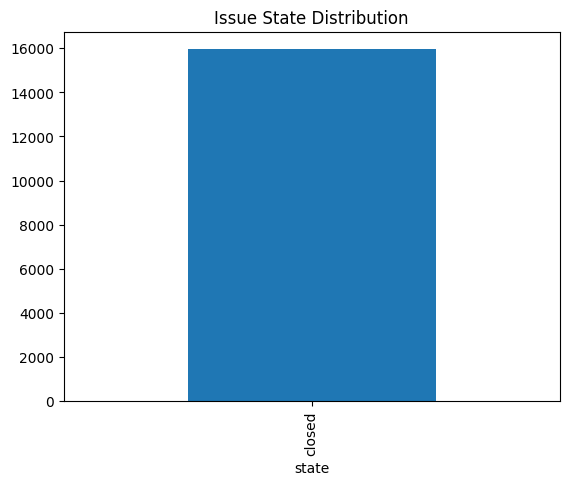

In [ ]:
df_raw['state'].value_counts().plot(kind='bar')
plt.title('Issue State Distribution')
plt.show()

In [ ]:
df_raw['state'].value_counts()

,count
state,
closed,15955


**Filter Useful Columns (`df_lean` Creation)**


In [ ]:
#Filter the useful columns
useful_cols = ['title', 'body', 'labels', 'comments']
df_lean = df_raw[useful_cols].copy()
df_lean.columns

Index(['title', 'body', 'labels', 'comments'], dtype='object')

In [ ]:
df_lean.head()

,title,body,labels,comments
0,Article mistake,### Describe the problem that you experienced\...,"[{'id': 226601219, 'url': 'https://api.github....",4
1,Able to change the window height even if IsRes...,### Describe the bug\n\nIf you set ExtendsCont...,"[{'id': 1005998261, 'url': 'https://api.github...",3
2,Introduce local for 'this' is not very useful,**Version Used**: VS 15.7\r\n\r\n**Steps to Re...,"[{'id': 165001069, 'url': 'https://api.github....",3
3,bundle exec rails webpacker:install:typescript...,webpacker version: 4.0.7\r\n\r\nIt appends the...,"[{'id': 495914230, 'url': 'https://api.github....",2
4,MediaSession play/pause events not propagated ...,### ExoPlayer Version\r\n\r\n2.18.0\r\n\r\n###...,"[{'id': 106814989, 'url': 'https://api.github....",1


**Code Block Count**

This feature can be useful for models to identify the technical nature or complexity of an issue.

In [ ]:
# Calculating text metrics
df_lean['code_block_count'] = df_lean['body'].apply(lambda x: x.count('```'))

**Handling Missing 'body' Values**
This is a crucial preprocessing step to ensure that text cleaning and NLP operations, which typically expect string inputs, do not encounter errors due to missing values.
:

In [ ]:
#Handling missing values
df_lean['body'] = df_lean['body'].fillna("")


**Cleaning and Combining Text Features**
Regular expression was used to clean the text to remove various types of noise.

Combine Text: This single column provides a comprehensive text feature for downstream NLP tasks.

In [ ]:
# --- 1. Define Helper Functions ---

def clean_text_body(text):
    # Check if text exists
    if not isinstance(text, str):
        return ""

    # Text cleaning by removing Code Blocks to reduce noise
    text = re.sub(r'```[\s\S]*?```', ' [CODE_BLOCK] ', text)

    # Text cleaning by removing Inline Code
    text = re.sub(r'`[^`]*`', ' [INLINE_CODE] ', text)

    # Text cleaning by removing URLs
    text = re.sub(r'http\S+', ' [URL] ', text)

    # Remove extra whitespace
    return re.sub(r'\s+', ' ', text).strip()

# Text cleaning by removing HTML, URL and Code Blocks
df_lean['clean_body'] = df_lean['body'].apply(clean_text_body)
# Combining title and body for a complete text feature
df_lean['combined_text'] = df_lean['title'] + " " + df_lean['clean_body']


**Handling Data Inconsistency using Taxonomy**

In [ ]:
# --- Taxonomy Option A: 3-Class Logic ---
# Merges 'Feature' and 'Enhancement' into a single positive class
def get_category_3_class(row_labels):
    label_str = str(row_labels).lower()

    if 'bug' in label_str:
        return 'Bug'
    # Merge occurs here
    if 'feature' in label_str or 'enhancement' in label_str:
        return 'Feature'
    if 'question' in label_str or 'help' in label_str or 'discussion' in label_str:
        return 'Question'

    return 'Other'

# --- Taxonomy Option B: 4-Class Logic ---
# Attempts to distinguish 'Feature' (New) from 'Enhancement' (Improvement)
def get_category_4_class(row_labels):
    label_str = str(row_labels).lower()

    if 'bug' in label_str:
        return 'Bug'
    # Split occurs here
    if 'feature' in label_str:
        return 'Feature'
    # We check for 'documentation' AND 'docs' to catch abbreviations
    if 'documentation' in label_str or 'docs' in label_str:
        return 'Documentation'
    if 'enhancement' in label_str:
        return 'Enhancement'
    if 'question' in label_str or 'help' in label_str or 'discussion' in label_str:
        return 'Question'

    return 'Other'

# We create TWO columns to compare the distribution visually
if 'labels' in df_lean.columns:
    df_lean['issue_type_3'] = df_lean['labels'].apply(get_category_3_class)
    df_lean['issue_type_4'] = df_lean['labels'].apply(get_category_4_class)

**Compare 3-Class vs 4-Class Issue Splits**


In [ ]:
# Comparison: 3 vs 4 Category Split
print(df_lean['issue_type_3'].value_counts())

print(df_lean['issue_type_4'].value_counts())

issue_type_3
Bug         13828
Other        1061
Feature       819
Question      247
Name: count, dtype: int64
issue_type_4
Bug              13828
Documentation      699
Other              509
Enhancement        446
Feature            353
Question           120
Name: count, dtype: int64


In [ ]:
df_lean['issue'] = df_lean['issue_type_4']
df_lean.drop(columns=['issue_type_3','issue_type_4'], inplace=True)
df_lean.drop(columns=['body'],inplace=True)
df_lean.columns

NameError: name 'df_lean' is not defined

In [ ]:
print(df_lean[df_lean['issue']=='Other']['title'])

NameError: name 'df_lean' is not defined

**Priority Classification**

The urgency of the issues was determined using a standardized, rule-based approach derived from established literature on GitHub priority labels by Caddy & Treude, 2024.


In [ ]:
def get_priority_level(row_labels):
    # Mapping priority based on the taxonomy defined by Caddy et al. (2024)
    # This replaces the old "Quality" check with a standardized research-based approach
    label_str = str(row_labels).lower()

    # High Priority Keywords (from Table 1 of the paper)
    if any(x in label_str for x in ['critical', 'urgent', 'high', 'major', 'p0', 'blocker']):
        return 'High'

    # Low Priority Keywords
    if any(x in label_str for x in ['low', 'stale', 'wontfix', 'minor', 'trivial', 'inactive']):
        return 'Low'

    # Default assumption if no priority label exists
    return 'Normal'


if 'labels' in df_lean.columns:
    df_lean['priority'] = df_lean['labels'].apply(get_priority_level)


In [ ]:
df_lean.head()
df_lean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15955 entries, 0 to 15954
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             15955 non-null  object
 1   labels            15955 non-null  object
 2   comments          15955 non-null  int64 
 3   code_block_count  15955 non-null  int64 
 4   clean_body        15955 non-null  object
 5   combined_text     15955 non-null  object
 6   issue             15955 non-null  object
 7   priority          15955 non-null  object
dtypes: int64(2), object(6)
memory usage: 997.3+ KB


**Saving Processed DataFrame**

In [ ]:
if 'df_lean' in locals():
    df_lean.to_pickle(f"{model_dir}/df_processed.pkl")

**SVM Model Training and Evaluation**


Training Data Shape: (15446, 8)
Step: Fine-Tuning SVM Model
Best Parameters Found: {'C': 1, 'class_weight': 'balanced'}
               precision    recall  f1-score   support

          Bug       0.94      0.96      0.95      2766
Documentation       0.63      0.59      0.61       140
  Enhancement       0.38      0.31      0.35        89
      Feature       0.36      0.28      0.31        71
     Question       0.12      0.04      0.06        24

     accuracy                           0.91      3090
    macro avg       0.49      0.44      0.46      3090
 weighted avg       0.89      0.91      0.90      3090



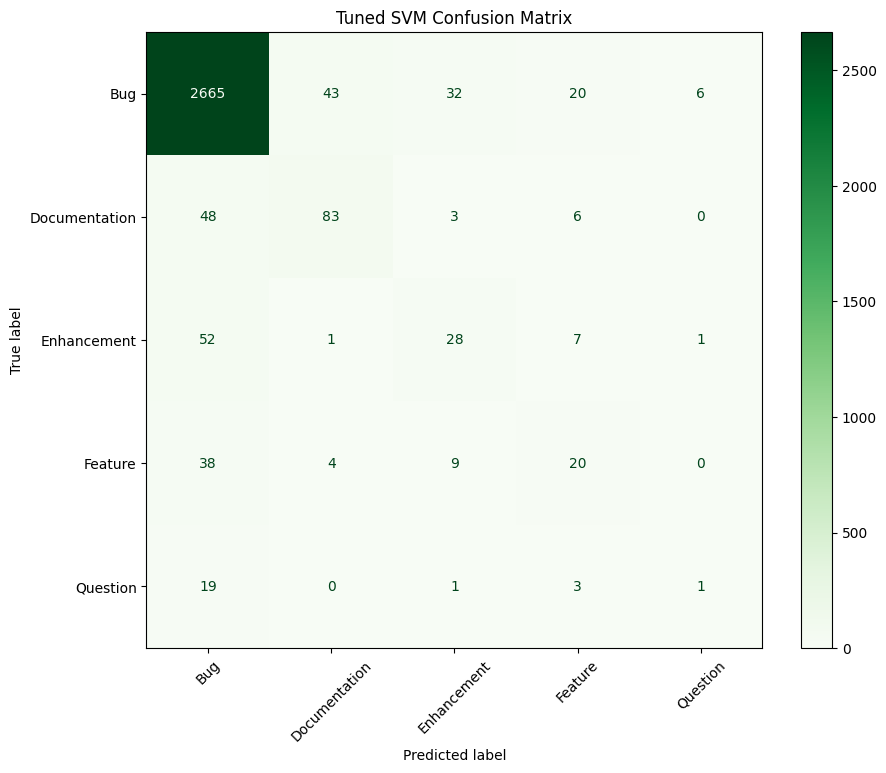

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# We filter out 'Other' to focus on specific categories we defined
df_model = df_lean[df_lean['issue'] != 'Other'].copy()
X = df_model['combined_text']
y = df_model['issue']

print(f"Training Data Shape: {df_model.shape}")

# 2. Split Data (80% Train, 20% Test)
# Stratify ensures we maintain the same ratio of bugs/features in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Vectorize Text (Convert words to numbers)
# limiting to top 5000 words to keep it fast
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 4. Fine-Tune Model (Grid Search)
print("Step: Fine-Tuning SVM Model")
from sklearn.model_selection import GridSearchCV

# Defining the "Grid" of options to test
# 'C': Controls how strict the model is (Lower = simpler, Higher = stricter)
# 'class_weight': 'balanced' forces the model to pay attention to small classes (like Question)
param_grid = {
    'C': [0.1, 1, 5, 10],
    'class_weight': ['balanced', None]
}

# Run the search (CV=3 means it double-checks results 3 times)
# scoring='f1_macro' optimizes for the average performance across ALL classes, not just Bugs
grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_vec, y_train)

print(f"Best Parameters Found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# 5. Evaluate Best Model
y_pred = best_model.predict(X_test_vec)

# Print metrics
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', ax=ax)
plt.title("Tuned SVM Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

**Saving SVM Model and Vectorizer**

Using the `joblib` library (imported earlier) for efficient serialization and deserialization of Python objects.

In [ ]:
try:
    # Save the vectorizer
    if 'tfidf' in locals():
        joblib.dump(tfidf, f"{model_dir}/tfidf_vectorizer.pkl")

    # Save the model
    # Check if we have a tuned grid model (best_model) or a basic svm_model
    if 'best_model' in locals():
        # This is from your fine-tuning step
        joblib.dump(best_model, f"{model_dir}/svm_model.pkl")
        print("SVM Classifier (Tuned Best Model) & Vectorizer saved.")
    elif 'grid_search' in locals() and hasattr(grid_search, 'best_estimator_'):
        # Fallback if best_model var isn't set but grid_search is
        joblib.dump(grid_search.best_estimator_, f"{model_dir}/svm_model.pkl")
        print("SVM Classifier (Grid Best Estimator) & Vectorizer saved.")
    elif 'svm_model' in locals():
        # Fallback to basic model
        joblib.dump(svm_model, f"{model_dir}/svm_model.pkl")
        print("SVM Classifier (Basic) & Vectorizer saved.")
    else:
        print("No SVM model found to save.")
except Exception as e:
    print(f"An error occurred during saving: {e}")

SVM Classifier (Tuned Best Model) & Vectorizer saved.


**Random Forest Model Training and Evaluation**


New Feature Shape: (12356, 5001) (Text + 1 Metadata Feature)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

          Bug       0.90      1.00      0.95      2766
Documentation       0.67      0.19      0.29       140
  Enhancement       0.00      0.00      0.00        89
      Feature       1.00      0.04      0.08        71
     Question       0.00      0.00      0.00        24

     accuracy                           0.90      3090
    macro avg       0.51      0.24      0.26      3090
 weighted avg       0.86      0.90      0.86      3090



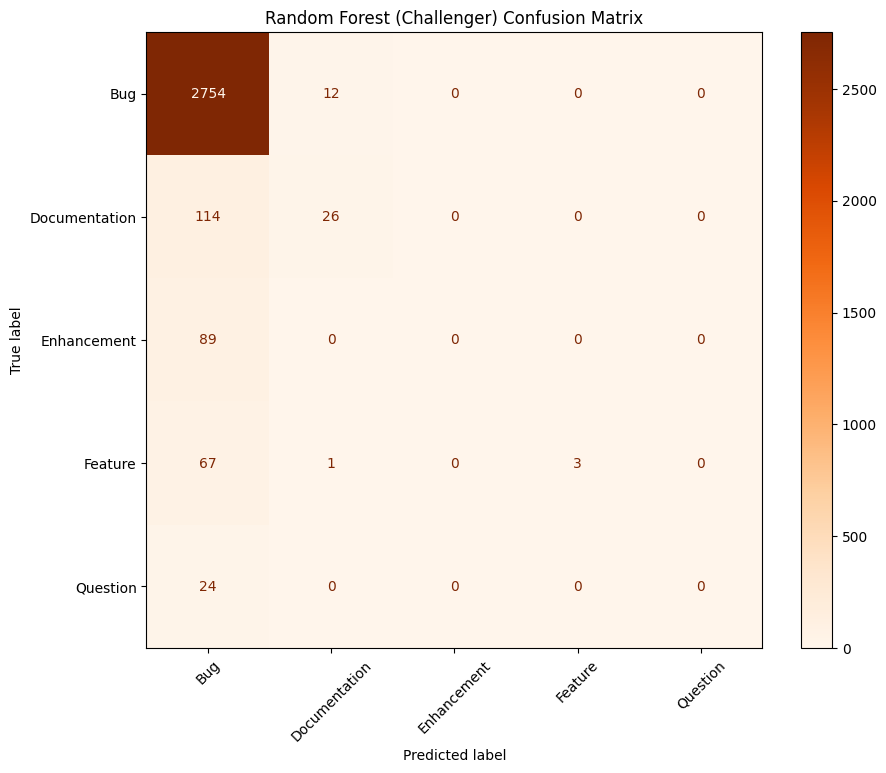

Top 10 Most Important Features for Random Forest:
feature: 0.0058
add: 0.0060
expected: 0.0072
inline_code: 0.0072
reproduce: 0.0086
version: 0.0110
bug: 0.0122
docs: 0.0133
url: 0.0140
documentation: 0.0248


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
import numpy as np

# 1. Prepare Metadata
# We need to match the metadata to the exact rows in X_train and X_test
# Since train_test_split shuffled indices, we use .loc to fetch the right values
train_code_counts = df_model.loc[X_train.index, 'code_block_count'].values.reshape(-1, 1)
test_code_counts = df_model.loc[X_test.index, 'code_block_count'].values.reshape(-1, 1)


# 2. Combine Features (Text + Metadata)
# hstack stacks the sparse TF-IDF matrix next to the dense metadata array
X_train_rf = hstack([X_train_vec, train_code_counts])
X_test_rf = hstack([X_test_vec, test_code_counts])

print(f"New Feature Shape: {X_train_rf.shape} (Text + 1 Metadata Feature)")

# 3. Train Random Forest
# We use class_weight='balanced' to give it a fair fighting chance against the imbalance
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train)

# 4. Evaluate
y_pred_rf = rf_model.predict(X_test_rf)

# Metrics
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Oranges', ax=ax)
plt.title("Random Forest (Challenger) Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

# 5. Feature Importance Analysis
# Did the code blocks actually help?
feature_names = list(tfidf.get_feature_names_out()) + ['code_block_count']
importances = rf_model.feature_importances_

# Get indices of top 10 features
top_indices = np.argsort(importances)[-10:]

print("Top 10 Most Important Features for Random Forest:")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

**Tuned Random Forest Model Training and Evaluation**

Running Grid Search for Random Forest... (This may take 2-3 minutes)
Best RF Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'n_estimators': 100}

Random Forest (Tuned) Classification Report:
               precision    recall  f1-score   support

          Bug       0.95      0.82      0.88      2766
Documentation       0.38      0.68      0.49       140
  Enhancement       0.12      0.61      0.20        89
      Feature       0.38      0.11      0.17        71
     Question       0.00      0.00      0.00        24

     accuracy                           0.78      3090
    macro avg       0.37      0.44      0.35      3090
 weighted avg       0.88      0.78      0.82      3090



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


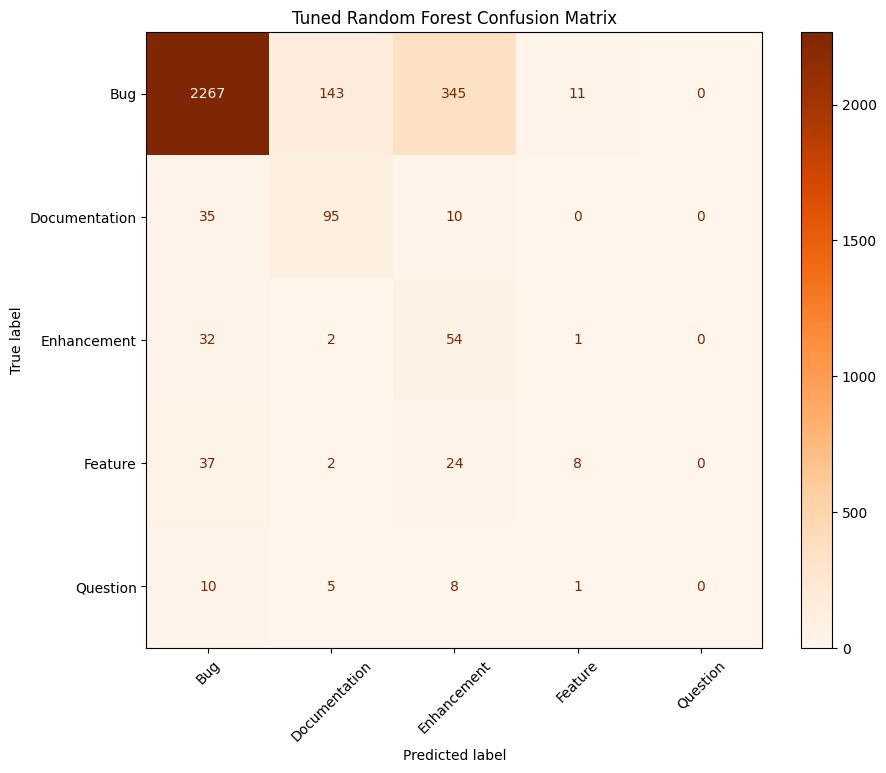

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Define the Parameter Grid
# We test if limiting depth helps (prevents overfitting) or if strict weights help
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],  # None = deep complex trees, 20 = simpler trees
    'class_weight': ['balanced', 'balanced_subsample'] # Try different weighting strategies
}

# 2. Run Grid Search
print("Running Grid Search for Random Forest... (This may take 2-3 minutes)")
# n_jobs=-1 uses all processors to speed it up
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,
    scoring='f1_macro' # Optimize for minority classes!
)
rf_grid.fit(X_train_rf, y_train)

# 3. Best Results
print(f"Best RF Parameters: {rf_grid.best_params_}")
best_rf = rf_grid.best_estimator_

# 4. Evaluate Best RF Model
y_pred_rf_tuned = best_rf.predict(X_test_rf)

print("\nRandom Forest (Tuned) Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))

# Confusion Matrix for Tuned RF
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned, cmap='Oranges', ax=ax)
plt.title("Tuned Random Forest Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

**Saving the Tuned Random Forest Model**

This cell uses the `joblib` library (imported earlier) to save the `best_rf` model, which is the optimized `RandomForestClassifier` obtained from the `GridSearchCV` process.

In [ ]:
joblib.dump(rf_grid.best_estimator_, f"{model_dir}/rf_model.pkl")
print("Random Forest (Tuned) saved.")

Random Forest (Tuned) saved.


**LDA Model Training and Topic Discovery**


Topic 0: windows, build, response_, _no, 10, package, operating, install, running, image
Topic 1: type, set, value, function, line, user, message, data, used, test
Topic 2: _no, response_, problem, page, information, description, add, additional, result, output
Topic 3: image, issues, link, page, src, width, img, alt, react, component
Topic 4: text, click, window, open, windows, button, os, screen, 10, select


/tmp/ipython-input-2777077381.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dominant_topic', data=df_lean, palette='pastel', ax=ax)


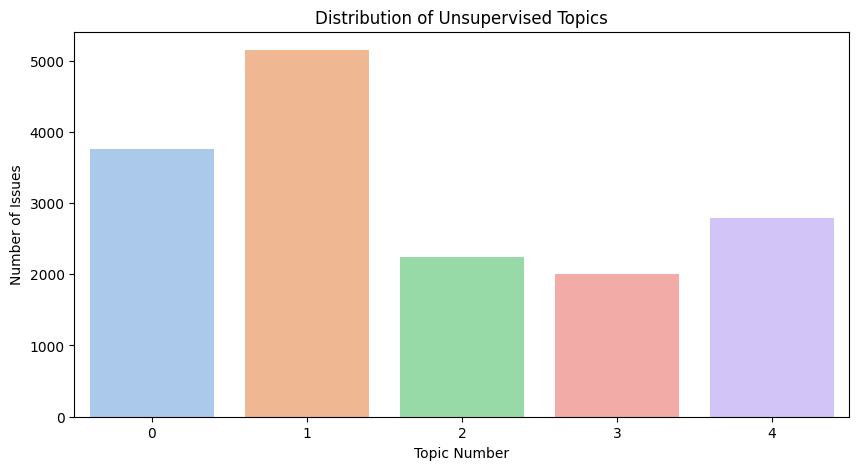

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# 1. Define Custom Stop Words (The "Noise Filter")
# Standard English stop words aren't enough. We need to remove generic GitHub jargon
# so the model focuses on the *specific* problem (e.g., "login", "database").
github_stop_words = [
    'issue', 'version', 'code', 'error', 'file', 'using', 'use', 'like',
    'run', 'project', 'files', 'following', 'example', 'app', 'does',
    'bug', 'expected', 'behavior', 'actual', 'steps', 'reproduce', # Template words
    'inline_code', 'code_block', 'url' # Our own cleaning tokens
]
my_stop_words = list(ENGLISH_STOP_WORDS) + github_stop_words

# 2. Vectorize Text (Count Vectorizer)
# LDA works best with raw word counts, not TF-IDF scores
count_vec = CountVectorizer(max_features=1000, stop_words=my_stop_words, max_df=0.9, min_df=5)
X_lda = count_vec.fit_transform(df_lean['combined_text'])

# 3. Train LDA Model
# n_components=5: We ask the model to find exactly 5 hidden themes
lda = LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)
lda.fit(X_lda)

# 4. View Discovered Topics
feature_names = count_vec.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    # Get top 10 words for this topic
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

# 5. Assign Topics to Documents
# We define which topic is dominant for each issue
topic_values = lda.transform(X_lda)
df_lean['dominant_topic'] = topic_values.argmax(axis=1)

# Plot the distribution of topics found
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='dominant_topic', data=df_lean, palette='pastel', ax=ax)
plt.title("Distribution of Unsupervised Topics")
plt.xlabel("Topic Number")
plt.ylabel("Number of Issues")
plt.show()

**LDA Hyperparameter Tuning**

Optimizing the `LatentDirichletAllocation` model using `sklearn.model_selection.GridSearchCV`.


--- Step: Tuning LDA (Finding Optimal Topics) ---
Running Grid Search... (This may take a minute)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score: -634192.8206911742
Model Perplexity: 668.84


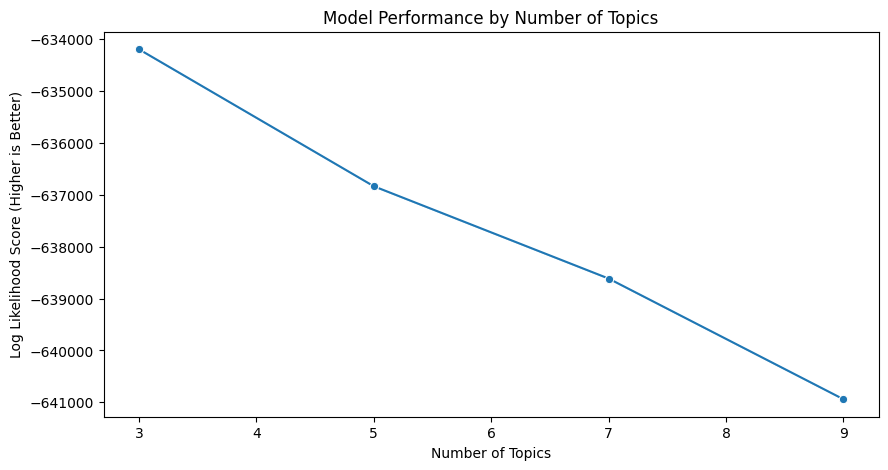

In [ ]:
# LDA Hyperparameter Tuning (Grid Search) ---
print("\n--- Step: Tuning LDA (Finding Optimal Topics) ---")
from sklearn.model_selection import GridSearchCV

# Define Search Grid
# We test 3, 5, 7, 9 topics to see which fits best
search_params = {
    'n_components': [3, 5, 7, 9],
    'learning_decay': [0.5, 0.7, 0.9]
}

# Initialize the Model
lda_tuning = LatentDirichletAllocation(random_state=42, n_jobs=-1)

# Init Grid Search Class
model = GridSearchCV(lda_tuning, param_grid=search_params, n_jobs=-1, verbose=1)

# Run the Grid Search
print("Running Grid Search... (This may take a minute)")
model.fit(X_lda)

# Best Model
best_lda_model = model.best_estimator_

print("Best Parameters:", model.best_params_)
print("Best Log Likelihood Score:", model.best_score_)
print(f"Model Perplexity: {best_lda_model.perplexity(X_lda):.2f}")

# Visualize Performance
results = pd.DataFrame(model.cv_results_)
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x='param_n_components', y='mean_test_score', marker='o')
plt.title("Model Performance by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Log Likelihood Score (Higher is Better)")
plt.show()

**Saving the LDA Model**

This cell uses the `joblib` library (imported earlier) to save the `best_lda_model`, which is the optimal `LatentDirichletAllocation` model identified through hyperparameter tuning.

In [ ]:
if 'best_lda_model' in locals():
    joblib.dump(best_lda_model,f"{model_dir}/lda_model.pkl")
    print("LDA Model saved")

LDA Model saved


**BERTopic Model Training and Topic Discovery**


In [ ]:
!pip install bertopic

from bertopic import BERTopic

# We use "all-MiniLM-L6-v2"
hf_model_id = "all-MiniLM-L6-v2"
print(f"Loading embedding model: {hf_model_id}...")

topic_model = BERTopic(
    embedding_model=hf_model_id,
    min_topic_size=30,
    verbose=True
)

topics, probs = topic_model.fit_transform(df_model['combined_text'].tolist())

print(topic_model.get_topic_info().head(10))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 12.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
2025-12-01 20:09:31,036 - BERTopic - Embedding - Transforming documents to embeddings.


Loading embedding model: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/483 [00:00<?, ?it/s]

2025-12-01 20:33:08,571 - BERTopic - Embedding - Completed ✓
2025-12-01 20:33:08,573 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-01 20:33:52,295 - BERTopic - Dimensionality - Completed ✓
2025-12-01 20:33:52,297 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-01 20:33:53,345 - BERTopic - Cluster - Completed ✓
2025-12-01 20:33:53,355 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-01 20:33:54,787 - BERTopic - Representation - Completed ✓


   Topic  Count                              Name  \
0     -1   7270          -1_the_inline_code_to_is   
1      0    317        0_table_php_database_query   
2      1    265     1_lemmy_url_browser_response_   
3      2    254             2_link_links_page_url   
4      3    249  3_window_rectangle_imgui_windows   
5      4    237          4_round_issue_id_exploit   
6      5    230      5_video_audio_handbrake_play   
7      6    218     6_python_model_onnx_fieldtrip   
8      7    199             7_nvim_neovim_vim_lua   
9      8    187    8_commit_git_gitui_inline_code   

                                      Representation  \
0  [the, inline_code, to, is, in, and, it, this, ...   
1  [table, php, database, query, entity, doctrine...   
2  [lemmy, url, browser, response_, _no, problem,...   
3  [link, links, page, url, broken, documentation...   
4  [window, rectangle, imgui, windows, mouse, scr...   
5  [round, issue, id, exploit, revision, byond, h...   
6  [video, audio, handbr

In [ ]:
topic_model.visualize_topics()

In [ ]:
len(topic_model.get_topics())

86

**Saving BERTopic Visualization**

I used the `topic_model` object (an instance of `BERTopic` from the previous cell) to generate and save an interactive topic visualization and saving it as a HTML file. The visual represents the relationships between topics, often as a 2D projection of topic centroids.

In [ ]:
# Save the visualization to HTML for your report
fig = topic_model.visualize_topics()
html_path = f"{model_dir}/bertopic_visualization.html"
fig.write_html(html_path)

**Save BERTopic Model**

In [ ]:
try:
    if 'topic_model' in locals():
        # BERTopic creates a folder or zip file
        topic_model.save(f"{model_dir}/bertopic_model", serialization="safetensors")
        print("BERTopic Model saved.")
except Exception as e:
    print(f"BERTopic Save Failed: {e}")

print(f"Folder Location: {model_dir}")

BERTopic Model saved.
Folder Location: /content/drive/MyDrive/saved_models


In [ ]:
# First, add the 'topics' from BERTopic as a new column to df_model
df_model['topic'] = topics

In [ ]:
# Filtering df_model where the 'topic' column is equal to 1, and display 'title', 'issue', and 'topic' columns.
print(df_model[df_model['topic'] == 1]['clean_body'].tail(20))

14843    <!-- Before creating a bug report, try disabli...
14895    ### Support guidelines - [X] I've read the [su...
14930    ### Requirements - [X] Is this a bug report? F...
14984    ### What is the URL where the issue is happeni...
15027    ### Requirements - [X] Is this a bug report? F...
15071    ### Describe the bug Total Commits (2023) shou...
15153    ### Describe the bug excuse me, as you can see...
15194    ### Steps To Reproduce ![Screenshot_2]( [URL] ...
15278    Steps to reproduce the bug: * Open a collabora...
15288    ### What is the URL where the issue is happeni...
15302    ![screencast-2017-10-27-00-38-44]( [URL] AFAIK...
15324    ### Description I'm loving this extension, but...
15410    ### What is the URL where the issue is happeni...
15428    <!-- Before creating a bug report, try disabli...
15470    ### Requirements - [X] Is this a bug report? F...
15579    ### What is the URL where the issue is happeni...
15730    ### Description This feature seems broken, eve.

**Loading LDA Model**

In [ ]:
lda_loaded = joblib.load(f"{model_dir}/lda_model.pkl")


**Comparing LDA and BERTopic Models**


Aligning data... Processing 15446 documents.
Transforming text for LDA...
Using stored BERTopic labels...
Adjusted Rand Index (ARI): 0.019


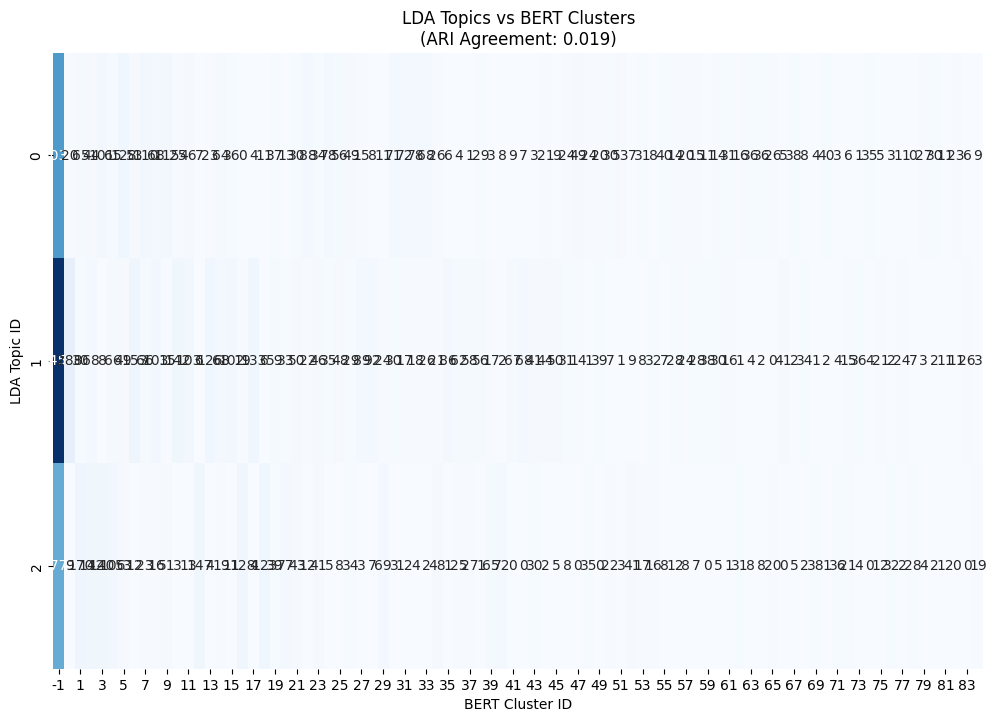

In [ ]:
from sklearn.metrics import adjusted_rand_score
# --- 1. Define the Helper Functions directly here (so Import isn't needed) ---
def compare_models(lda_labels, bert_labels):
    ari = adjusted_rand_score(lda_labels, bert_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")

    df_compare = pd.DataFrame({'LDA Topic': lda_labels, 'BERT Cluster': bert_labels})
    confusion_matrix = pd.crosstab(df_compare['LDA Topic'], df_compare['BERT Cluster'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"LDA Topics vs BERT Clusters\n(ARI Agreement: {ari:.3f})")
    plt.ylabel("LDA Topic ID")
    plt.xlabel("BERT Cluster ID")
    plt.show()

def compare_models_aligned(lda_model, lda_vectorizer, bert_model, shared_text_list):
    print(f"Aligning data... Processing {len(shared_text_list)} documents.")

    # Get LDA Labels
    print("Transforming text for LDA...")
    try:
        # We need to re-vectorize the text because LDA expects numbers, not strings
        X_new_lda = lda_vectorizer.transform(shared_text_list)
        lda_output = lda_model.transform(X_new_lda)
        lda_labels = lda_output.argmax(axis=1)
    except Exception as e:
        print(f"Error with LDA Vectorizer: {e}")
        print("Did you re-run the 'Vectorize Text' cell? LDA needs the 'count_vec' object!")
        return

    # Get BERT Labels
    # We check if the topics are already calculated for this specific list
    if hasattr(bert_model, 'topics_') and len(bert_model.topics_) == len(shared_text_list):
        print("Using stored BERTopic labels...")
        bert_labels = np.array(bert_model.topics_)
    else:
        print("Re-calculating BERTopic labels...")
        bert_labels, _ = bert_model.transform(shared_text_list)

    compare_models(lda_labels, bert_labels)

# --- 2. Run the Comparison with YOUR Variables ---
# Variable 1: lda_loaded (The model you just loaded from disk)
# Variable 2: count_vec  (The dictionary - MUST be in memory. Re-run Step 2 if missing!)
# Variable 3: topic_model (Your BERTopic model)
# Variable 4: df_model   (The data you want to compare on)

compare_models_aligned(
    lda_model=lda_loaded,
    lda_vectorizer=count_vec,
    bert_model=topic_model,
    shared_text_list=df_model['combined_text'].tolist())

**LDA and BERTopic Model Comparison (noise removed)**

The `compare_models` function (called internally by `compare_models_aligned`) is configured to `ignore_outliers=True`, meaning BERTopic's noise cluster (-1) is excluded from the ARI calculation and confusion matrix, focusing on the agreement of actual topics.


Aligning data... Processing 15446 documents.
Transforming text for LDA...
Using stored BERTopic labels...
BERTopic Noise (-1) Count: 7270/15446 (47.1%)
[INFO] Filtering out noise (-1) to see underlying structure...
Adjusted Rand Index (Clean Data): 0.020


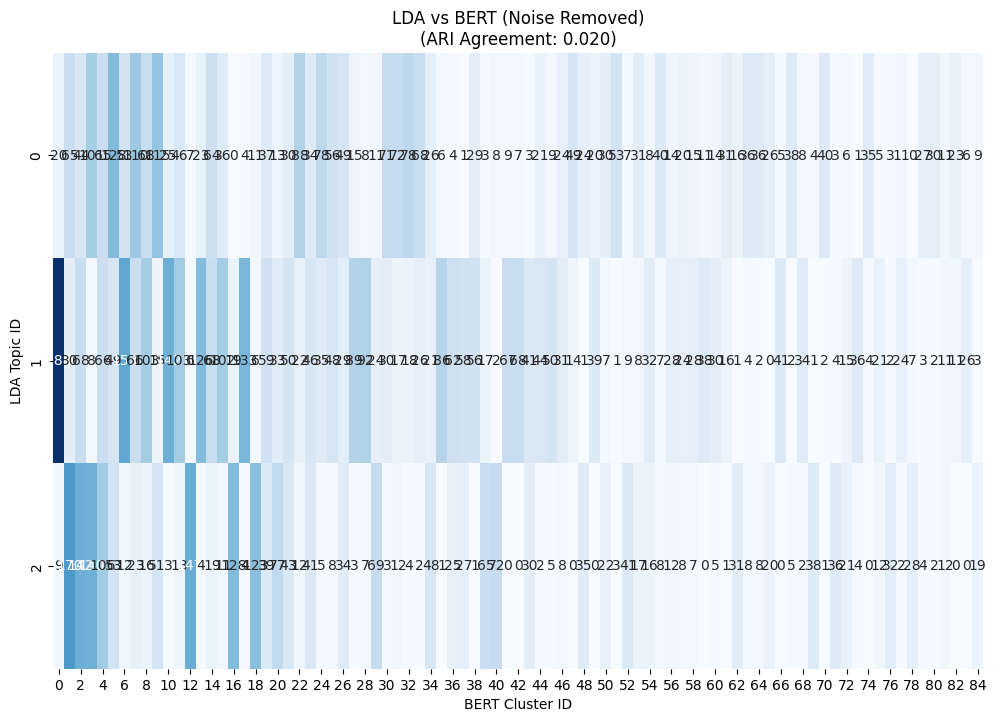

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import numpy as np

# --- 1. Define the Helper Functions directly here (so Import isn't needed) ---
def compare_models(lda_labels, bert_labels, ignore_outliers=True):
    """
    Plots agreement.
    If ignore_outliers is True, it removes BERTopic's -1 (Noise) category
    to see if the *actual* topics align.
    """
    df_compare = pd.DataFrame({'LDA Topic': lda_labels, 'BERT Cluster': bert_labels})

    # Calculate Noise Percentage
    noise_count = len(df_compare[df_compare['BERT Cluster'] == -1])
    total_count = len(df_compare)
    print(f"BERTopic Noise (-1) Count: {noise_count}/{total_count} ({noise_count/total_count:.1%})")

    if ignore_outliers and noise_count > 0:
        print("[INFO] Filtering out noise (-1) to see underlying structure...")
        df_compare = df_compare[df_compare['BERT Cluster'] != -1]

        if len(df_compare) == 0:
            print("[WARNING] ALL data is labeled as noise (-1). Your BERTopic model needs tuning (lower min_topic_size).")
            return

    # Recalculate ARI on the clean data
    ari = adjusted_rand_score(df_compare['LDA Topic'], df_compare['BERT Cluster'])
    print(f"Adjusted Rand Index (Clean Data): {ari:.3f}")

    confusion_matrix = pd.crosstab(df_compare['LDA Topic'], df_compare['BERT Cluster'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    title = f"LDA vs BERT (Noise Removed)\n(ARI Agreement: {ari:.3f})" if ignore_outliers else f"LDA vs BERT (Includes Noise)\n(ARI Agreement: {ari:.3f})"
    plt.title(title)
    plt.ylabel("LDA Topic ID")
    plt.xlabel("BERT Cluster ID")
    plt.show()

def compare_models_aligned(lda_model, lda_vectorizer, bert_model, shared_text_list):
    print(f"Aligning data... Processing {len(shared_text_list)} documents.")

    # Get LDA Labels
    print("Transforming text for LDA...")
    try:
        # We need to re-vectorize the text because LDA expects numbers, not strings
        X_new_lda = lda_vectorizer.transform(shared_text_list)
        lda_output = lda_model.transform(X_new_lda)
        lda_labels = lda_output.argmax(axis=1)
    except Exception as e:
        print(f"Error with LDA Vectorizer: {e}")
        print("Did you re-run the 'Vectorize Text' cell? LDA needs the 'count_vec' object!")
        return

    # Get BERT Labels
    # We check if the topics are already calculated for this specific list
    if hasattr(bert_model, 'topics_') and len(bert_model.topics_) == len(shared_text_list):
        print("Using stored BERTopic labels...")
        bert_labels = np.array(bert_model.topics_)
    else:
        print("Re-calculating BERTopic labels...")
        bert_labels, _ = bert_model.transform(shared_text_list)

    compare_models(lda_labels, bert_labels, ignore_outliers=True)

# --- 2. Run the Comparison with YOUR Variables ---
# Variable 1: lda_loaded (The model you just loaded from disk)
# Variable 2: count_vec  (The dictionary - MUST be in memory. Re-run Step 2 if missing!)
# Variable 3: topic_model (Your BERTopic model)
# Variable 4: df_model   (The data you want to compare on)

compare_models_aligned(
    lda_model=lda_loaded,
    lda_vectorizer=count_vec,
    bert_model=topic_model,
    shared_text_list=df_model['combined_text'].tolist()
)

## **AI Disclosure**                                                                     
This project utilized Google Gemini to generate portions of the code, which was then manually verified for logic and correctness.


# **DUMMY TEST**

### **Combining SVM and BERTopic for Automated Issue Processing**

This section provides a practical implementation of the combined SVM and BERTopic models to automate the processing of new GitHub issues. The workflow involves:

1.  **Loading Saved Models**: The pre-trained `TfidfVectorizer`, `LinearSVC` (SVM), `BERTopic`, and `LatentDirichletAllocation` (LDA, although BERTopic is prioritized for topic discovery) models are loaded from the `model_dir`.
2.  **`process_new_issue(issue_title, issue_body)` Function**: This function takes the title and body of a new issue, performs text cleaning, uses SVM for supervised classification, and leverages BERTopic for unsupervised topic discovery. It also assigns a priority level.
3.  **Demonstration**: A sample issue is processed through this function to illustrate the automated output.

In [9]:
!pip install bertopic

import joblib
import pandas as pd
import re
import numpy as np
from bertopic import BERTopic # Import BERTopic for loading its model

# Ensure model_dir is defined within this cell's scope
model_dir = "/content/drive/MyDrive/saved_models"

# --- 1. Load the Saved Models and Vectorizer ---
print(f"Loading models from: {model_dir}/")
tfidf_vectorizer = joblib.load(f"{model_dir}/tfidf_vectorizer.pkl")
svm_model = joblib.load(f"{model_dir}/svm_model.pkl")
# Correctly load BERTopic model, which is saved as a directory
bertopic_model = BERTopic.load(f"{model_dir}/bertopic_model")

# The clean_text_body and get_priority_level functions are needed
# Re-define them here for self-contained execution if this cell is run independently
def clean_text_body(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'```[\s\S]*?```', ' [CODE_BLOCK] ', text)
    text = re.sub(r'`[^`]*`', ' [INLINE_CODE] ', text)
    text = re.sub(r'http\S+', ' [URL] ', text)
    return re.sub(r'\s+', ' ', text).strip()

def get_priority_level(label_str):
    label_str = str(label_str).lower()
    if any(x in label_str for x in ['critical', 'urgent', 'high', 'major', 'p0', 'blocker']):
        return 'High'
    if any(x in label_str for x in ['low', 'stale', 'wontfix', 'minor', 'trivial', 'inactive']):
        return 'Low'
    return 'Normal'

# --- 2. Define the Automated Processing Function ---
def process_new_issue(issue_title, issue_body, issue_labels=None):
    print("\n--- Processing New Issue ---")

    # 2.1. Text Cleaning and Combination
    clean_b = clean_text_body(issue_body)
    combined_t = issue_title + " " + clean_b
    print(f"Cleaned Combined Text: {combined_t[:100]}...") # Show first 100 chars

    # 2.2. SVM Classification (Issue Type)
    X_vec = tfidf_vectorizer.transform([combined_t])
    svm_prediction = svm_model.predict(X_vec)[0]
    print(f"Predicted Issue Type (SVM): {svm_prediction}")

    # 2.3. BERTopic Topic Discovery
    bertopic_topic_id, _ = bertopic_model.transform([combined_t])

    # Handle BERTopic noise cluster (-1)
    if bertopic_topic_id[0] == -1:
        bertopic_topic_name = "(Noise/Outlier - No specific topic)"
        bertopic_keywords = []
    else:
        # Fetching info from get_topic_info might be more robust
        topic_info_df = bertopic_model.get_topic_info()
        # Filter for the specific topic_id and then get the 'Name' column
        bertopic_topic_name = topic_info_df[topic_info_df['Topic'] == bertopic_topic_id[0]]['Name'].iloc[0]
        # Get top 5 keywords from get_topic for the topic
        bertopic_keywords = [word for word, _ in bertopic_model.get_topic(bertopic_topic_id[0])[:5]]

    print(f"Discovered Topic (BERTopic ID): {bertopic_topic_id[0]}")
    print(f"BERTopic Name: {bertopic_topic_name}")
    print(f"Top Keywords for BERTopic: {', '.join(bertopic_keywords)}")

    # 2.4. Priority Classification (using provided labels or defaulting if none)
    if issue_labels:
        priority = get_priority_level(issue_labels)
    else:
        priority = "Normal" # Default if no labels provided
    print(f"Assigned Priority: {priority}")

    return {
        "title": issue_title,
        "body": issue_body,
        "predicted_issue_type": svm_prediction,
        "bertopic_id": bertopic_topic_id[0],
        "bertopic_name": bertopic_topic_name,
        "bertopic_keywords": bertopic_keywords,
        "priority": priority
    }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Loading models from: /content/drive/MyDrive/saved_models/


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
# Example 1: A clear bug report
issue_1_title = "Critical: Database connection fails after upgrade"
issue_1_body = "After upgrading to v2.3.0, the application is unable to connect to the PostgreSQL database. Logs show `ERROR: Connection refused` [CODE_BLOCK] and the system crashes. This needs urgent attention."
issue_1_labels = "bug, critical, p0"

results_1 = process_new_issue(issue_1_title, issue_1_body, issue_1_labels)
print("\n--- Results for Issue 1 ---")
for k, v in results_1.items():
    print(f"{k}: {v}")

# Example 2: A new feature request
issue_2_title = "Feature Request: Dark mode for UI"
issue_2_body = "It would be great to have a dark mode option in the user interface. This is a common feature [INLINE_CODE] in many applications today and improves user experience, especially in low-light conditions."
issue_2_labels = "enhancement, ux"

results_2 = process_new_issue(issue_2_title, issue_2_body, issue_2_labels)
print("\n--- Results for Issue 2 ---")
for k, v in results_2.items():
    print(f"{k}: {v}")


# Example 3: A generic question that might fall into BERTopic noise
issue_3_title = "Question about project setup"
issue_3_body = "Hi, I'm new to this project. How do I get started with the development environment? I've cloned the repo, but not sure what to do next."
issue_3_labels = "question, help wanted"

results_3 = process_new_issue(issue_3_title, issue_3_body, issue_3_labels)
print("\n--- Results for Issue 3 ---")
for k, v in results_3.items():
    print(f"{k}: {v}")


--- Processing New Issue ---
Cleaned Combined Text: Critical: Database connection fails after upgrade After upgrading to v2.3.0, the application is unab...
Predicted Issue Type (SVM): Bug


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-10 00:16:31,452 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Discovered Topic (BERTopic ID): 0
BERTopic Name: 0_table_php_database_query
Top Keywords for BERTopic: table, php, database, query, entity
Assigned Priority: High

--- Results for Issue 1 ---
title: Critical: Database connection fails after upgrade
body: After upgrading to v2.3.0, the application is unable to connect to the PostgreSQL database. Logs show `ERROR: Connection refused` [CODE_BLOCK] and the system crashes. This needs urgent attention.
predicted_issue_type: Bug
bertopic_id: 0
bertopic_name: 0_table_php_database_query
bertopic_keywords: ['table', 'php', 'database', 'query', 'entity']
priority: High

--- Processing New Issue ---
Cleaned Combined Text: Feature Request: Dark mode for UI It would be great to have a dark mode option in the user interface...
Predicted Issue Type (SVM): Documentation


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-10 00:16:31,880 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Discovered Topic (BERTopic ID): 48
BERTopic Name: 48_dark_background_theme_mode
Top Keywords for BERTopic: dark, background, theme, mode, color
Assigned Priority: Normal

--- Results for Issue 2 ---
title: Feature Request: Dark mode for UI
body: It would be great to have a dark mode option in the user interface. This is a common feature [INLINE_CODE] in many applications today and improves user experience, especially in low-light conditions.
predicted_issue_type: Documentation
bertopic_id: 48
bertopic_name: 48_dark_background_theme_mode
bertopic_keywords: ['dark', 'background', 'theme', 'mode', 'color']
priority: Normal

--- Processing New Issue ---
Cleaned Combined Text: Question about project setup Hi, I'm new to this project. How do I get started with the development ...
Predicted Issue Type (SVM): Bug


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-10 00:16:32,028 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Discovered Topic (BERTopic ID): 44
BERTopic Name: 44_building_path_behave_check
Top Keywords for BERTopic: building, path, behave, check, ve
Assigned Priority: Normal

--- Results for Issue 3 ---
title: Question about project setup
body: Hi, I'm new to this project. How do I get started with the development environment? I've cloned the repo, but not sure what to do next.
predicted_issue_type: Bug
bertopic_id: 44
bertopic_name: 44_building_path_behave_check
bertopic_keywords: ['building', 'path', 'behave', 'check', 've']
priority: Normal
